In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Read Annotation

In [2]:
annotations_dir = 'face-mask-detection/annotations'
images_dir = 'face-mask-detection/images'

In [3]:
import glob
from xml.etree import ElementTree
information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': [], 'file': [], 'width': [], 'height': []}

for annotation in glob.glob(annotations_dir + '/*.xml'):
    tree = ElementTree.parse(annotation)
    
    for element in tree.iter():
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag: 
                    width = int(round(float(attribute.text)))
                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))    

        if 'object' in element.tag:
            for attribute in list(element):
                if 'name' in attribute.tag:
                    name = attribute.text                 
                    information['label'] += [name]
                    information['width'] += [width]
                    information['height'] += [height] 
                    information['file'] += [annotation.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            information['xmin'] += [xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            information['ymin'] += [ymin]                                
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            information['xmax'] += [xmax]                                
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            information['ymax'] += [ymax]

In [4]:
info = pd.DataFrame(information)

# Crop Images

In [5]:
info['annotation_file'] = info['file'] + '.xml'
info['image_file'] = info['file'] + '.png'
info['cropped_image_file'] = None
for i in range(len(info)):
    info['cropped_image_file'].iloc[i] = info.iloc[i, 5] + '_' + str(i) + '.png'

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [6]:
info

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,62,194,160,320,without_mask,maksssksksss299,301,400,maksssksksss299.xml,maksssksksss299.png,maksssksksss299_0.png
1,43,169,149,308,without_mask,maksssksksss528,301,400,maksssksksss528.xml,maksssksksss528.png,maksssksksss528_1.png
2,48,107,218,304,mask_weared_incorrect,maksssksksss272,275,400,maksssksksss272.xml,maksssksksss272.png,maksssksksss272_2.png
3,28,78,43,99,with_mask,maksssksksss514,400,267,maksssksksss514.xml,maksssksksss514.png,maksssksksss514_3.png
4,160,66,176,83,with_mask,maksssksksss514,400,267,maksssksksss514.xml,maksssksksss514.png,maksssksksss514_4.png
...,...,...,...,...,...,...,...,...,...,...,...
4067,271,73,278,82,without_mask,maksssksksss294,400,241,maksssksksss294.xml,maksssksksss294.png,maksssksksss294_4067.png
4068,236,91,243,99,without_mask,maksssksksss294,400,241,maksssksksss294.xml,maksssksksss294.png,maksssksksss294_4068.png
4069,236,76,243,83,without_mask,maksssksksss294,400,241,maksssksksss294.xml,maksssksksss294.png,maksssksksss294_4069.png
4070,264,76,268,82,with_mask,maksssksksss294,400,241,maksssksksss294.xml,maksssksksss294.png,maksssksksss294_4070.png


In [7]:
# for i in range(len(info)):
#     image_filepath = 'face-mask-detection/images/' + info.iloc[i, 9]
#     image = cv2.imread(image_filepath)
    
#     info['cropped_image_file'].iloc[i] = info.iloc[i, 5] + '_' + str(i) + '.png'
    
#     xmin = info.iloc[i, 0]
#     ymin = info.iloc[i, 1]
#     xmax = info.iloc[i, 2]
#     ymax = info.iloc[i, 3]
#     cropped_image = image[ymin:ymax, xmin:xmax]
    
#     cropped_image_directory = os.path.join('face-mask-detection/cropped_images', info['cropped_image_file'].iloc[i]) 
#     cv2.imwrite(cropped_image_directory, cropped_image)

In [8]:
#info

# Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(info, test_size=0.20, random_state=66)

In [10]:
train_df['label'].value_counts() # can change the dataset https://www.kaggle.com/datasets/hadjadjib/facemask-recognition-dataset

with_mask                2608
without_mask              549
mask_weared_incorrect     100
Name: label, dtype: int64

In [11]:
train_df.shape, test_df.shape

((3257, 11), (815, 11))

# Read Image

In [12]:
images = []
outputs = []

for i in range(len(train_df)):
    cropped_image_path = 'face-mask-detection/cropped_images/' + train_df['cropped_image_file'].iloc[i]
    cropped_image = cv2.imread(cropped_image_path)
    img = cv2.resize(cropped_image, (32,32))
    images.append(img)
    outputs.append(train_df['label'].iloc[i])

In [13]:
x_train = np.array(images)
y_train = np.array(outputs)
print("x_train shape : ", x_train.shape)
print("y_train shape : ", y_train.shape)

x_train shape :  (3257, 32, 32, 3)
y_train shape :  (3257,)


In [14]:
images = []
outputs = []

for i in range(len(test_df)):
    cropped_image_path = 'face-mask-detection/cropped_images/' + test_df['cropped_image_file'].iloc[i]
    cropped_image = cv2.imread(cropped_image_path)
    img = cv2.resize(cropped_image, (32,32))
    images.append(img)
    outputs.append(train_df['label'].iloc[i])

In [15]:
x_test = np.array(images)
y_test = np.array(outputs)
print("x_test shape : ", x_test.shape)
print("y_test shape : ", y_test.shape)

x_test shape :  (815, 32, 32, 3)
y_test shape :  (815,)


In [16]:
# convert to integers
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
y_train = label.fit_transform(y_train)
y_test = label.fit_transform(y_test)
y_train.shape, y_test.shape

((3257,), (815,))

In [17]:
# convert to one-hot-encoding
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape, y_test.shape

((3257, 3), (815, 3))

# Build Model

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout

model = Sequential()
model.add(Conv2D(16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (32,32,3)))
model.add(MaxPool2D(pool_size = 2))
model.add(Conv2D(32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPool2D(pool_size = 2))
model.add(Conv2D(64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 64)          0

In [20]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [43]:
history = model.fit(x_train, y_train, validation_split=0.3, epochs=20,
          callbacks = EarlyStopping(patience = 2)) 

Epoch 1/20
72/72 [==============================] - 1s 18ms/step - loss: 0.1630 - accuracy: 0.9482 - val_loss: 0.2563 - val_accuracy: 0.9356
Epoch 2/20
72/72 [==============================] - 1s 18ms/step - loss: 0.1535 - accuracy: 0.9465 - val_loss: 0.3209 - val_accuracy: 0.9356
Epoch 3/20
72/72 [==============================] - 1s 17ms/step - loss: 0.1496 - accuracy: 0.9495 - val_loss: 0.2292 - val_accuracy: 0.9284
Epoch 4/20
72/72 [==============================] - 1s 17ms/step - loss: 0.1489 - accuracy: 0.9513 - val_loss: 0.2243 - val_accuracy: 0.9376
Epoch 5/20
72/72 [==============================] - 1s 18ms/step - loss: 0.1550 - accuracy: 0.9491 - val_loss: 0.1939 - val_accuracy: 0.9427
Epoch 6/20
72/72 [==============================] - 1s 18ms/step - loss: 0.1047 - accuracy: 0.9645 - val_loss: 0.2260 - val_accuracy: 0.9315
Epoch 7/20
72/72 [==============================] - 1s 18ms/step - loss: 0.1090 - accuracy: 0.9671 - val_loss: 0.2663 - val_accuracy: 0.9243


In [46]:
result = pd.DataFrame(history.history)
result

,loss,accuracy,val_loss,val_accuracy
0,0.162969,0.948223,0.256256,0.935583
1,0.153501,0.946468,0.320852,0.935583
2,0.149617,0.949539,0.229222,0.928425
3,0.148887,0.951294,0.224342,0.937628
4,0.154997,0.949100,0.193851,0.942740
5,0.104718,0.964458,0.225964,0.931493
6,0.109027,0.967091,0.266275,0.924335


<AxesSubplot:>

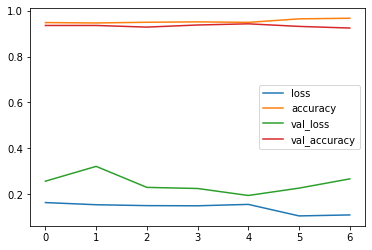

In [47]:
result.plot()

# Evaluate on Test Data

In [52]:
model.evaluate(x_test, y_test)

26/26 [==============================] - 0s 5ms/step - loss: 2.7926 - accuracy: 0.6331


[2.79264497756958, 0.633128821849823]

# Data Augmentation

In [34]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(info, test_size=0.2, random_state=66)
test_df, val_df = train_test_split(test_df, test_size=0.7, random_state=66)

In [36]:
train_df.shape, val_df.shape, test_df.shape

((3257, 11), (571, 11), (244, 11))

## separate each class into a folder under train & test folders

In [39]:
for i in range(len(train_df)):
    image_filepath = 'face-mask-detection/images/' + train_df.iloc[i, 9]
    image = cv2.imread(image_filepath)
    
    xmin = train_df.iloc[i, 0]
    ymin = train_df.iloc[i, 1]
    xmax = train_df.iloc[i, 2]
    ymax = train_df.iloc[i, 3]
    cropped_image = image[ymin:ymax, xmin:xmax]
    
    cropped_image_directory = os.path.join('face-mask-detection/train', 
                                           train_df['label'].iloc[i], 
                                           train_df['cropped_image_file'].iloc[i]) 
    cv2.imwrite(cropped_image_directory, cropped_image)

In [40]:
for i in range(len(val_df)):
    image_filepath = 'face-mask-detection/images/' + val_df.iloc[i, 9]
    image = cv2.imread(image_filepath)
    
    xmin = val_df.iloc[i, 0]
    ymin = val_df.iloc[i, 1]
    xmax = val_df.iloc[i, 2]
    ymax = val_df.iloc[i, 3]
    cropped_image = image[ymin:ymax, xmin:xmax]
    
    cropped_image_directory = os.path.join('face-mask-detection/val', 
                                           val_df['label'].iloc[i], 
                                           val_df['cropped_image_file'].iloc[i]) 
    cv2.imwrite(cropped_image_directory, cropped_image)

In [41]:
for i in range(len(test_df)):
    image_filepath = 'face-mask-detection/images/' + test_df.iloc[i, 9]
    image = cv2.imread(image_filepath)
    
    xmin = test_df.iloc[i, 0]
    ymin = test_df.iloc[i, 1]
    xmax = test_df.iloc[i, 2]
    ymax = test_df.iloc[i, 3]
    cropped_image = image[ymin:ymax, xmin:xmax]
    
    cropped_image_directory = os.path.join('face-mask-detection/test', 
                                           test_df['label'].iloc[i], 
                                           test_df['cropped_image_file'].iloc[i]) 
    cv2.imwrite(cropped_image_directory, cropped_image)

## data generator

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, vertical_flip=False, zoom_range=0.1, 
    shear_range=0.2, width_shift_range=0.1, height_shift_range=0.1, rotation_range=4)

test_gen = ImageDataGenerator(rescale=1.0 / 255)
 
train_generator = train_gen.flow_from_directory(
    directory='face-mask-detection/train', 
    target_size = (35,35),
    class_mode="categorical", batch_size=8, shuffle=True
)

val_generator = test_gen.flow_from_directory(
    directory='face-mask-detection/val', 
    target_size = (35,35),
    class_mode="categorical", batch_size=8, shuffle=True
)

test_generator = test_gen.flow_from_directory(
    directory='face-mask-detection/test', 
    target_size = (35,35),
    class_mode="categorical", batch_size=1, shuffle=False
)

Found 3257 images belonging to 3 classes.
Found 571 images belonging to 3 classes.
Found 244 images belonging to 3 classes.


In [30]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout

model2 = Sequential()
model2.add(Conv2D(16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (32,32,3)))
model2.add(MaxPool2D(pool_size = 2))
model2.add(Conv2D(32, kernel_size = 3,  padding='same', activation = 'relu'))
model2.add(MaxPool2D(pool_size = 2))
model2.add(Conv2D(64, kernel_size = 3,  padding='same', activation = 'relu'))
model2.add(MaxPool2D(2))
model2.add(Dropout(0.3))
model2.add(Flatten())
model2.add(Dense(500, activation = 'relu'))
model2.add(Dropout(0.3))
model2.add(Dense(units = 3, activation = 'softmax'))

In [31]:
model2.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [56]:
history2 = model2.fit_generator(generator=train_generator, validation_data=val_generator, 
                                epochs=50, steps_per_epoch=50, shuffle=True,
                                callbacks = EarlyStopping(patience = 5, monitor='val_loss')) 

Epoch 1/50
50/50 [==============================] - 1s 15ms/step - loss: 0.1556 - accuracy: 0.9525 - val_loss: 0.1560 - val_accuracy: 0.9422
Epoch 2/50
50/50 [==============================] - 1s 15ms/step - loss: 0.2228 - accuracy: 0.9300 - val_loss: 0.1593 - val_accuracy: 0.9457
Epoch 3/50
50/50 [==============================] - 1s 15ms/step - loss: 0.1410 - accuracy: 0.9450 - val_loss: 0.2054 - val_accuracy: 0.9317
Epoch 4/50
50/50 [==============================] - 1s 15ms/step - loss: 0.1565 - accuracy: 0.9500 - val_loss: 0.1425 - val_accuracy: 0.9475
Epoch 5/50
50/50 [==============================] - 1s 14ms/step - loss: 0.1341 - accuracy: 0.9517 - val_loss: 0.1362 - val_accuracy: 0.9510
Epoch 6/50
50/50 [==============================] - 1s 15ms/step - loss: 0.1926 - accuracy: 0.9500 - val_loss: 0.1552 - val_accuracy: 0.9492
Epoch 7/50
50/50 [==============================] - 1s 15ms/step - loss: 0.1654 - accuracy: 0.9500 - val_loss: 0.1422 - val_accuracy: 0.9527
Epoch 8/50
50

In [57]:
result = pd.DataFrame(history2.history)
result

,loss,accuracy,val_loss,val_accuracy
0,0.155598,0.952500,0.155965,0.942207
1,0.222758,0.930000,0.159343,0.945709
2,0.140997,0.945000,0.205360,0.931699
3,0.156488,0.950000,0.142516,0.947461
4,0.134127,0.951654,0.136250,0.950963
5,0.192623,0.950000,0.155190,0.949212
6,0.165432,0.950000,0.142181,0.952715
7,0.150211,0.952500,0.197059,0.933450
8,0.183691,0.932500,0.156042,0.942207
9,0.144928,0.940000,0.140779,0.942207


[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'accuracy')]

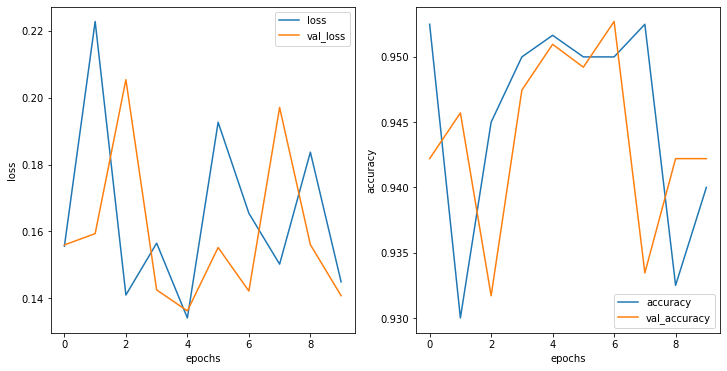

In [59]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
result.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
ax[0].set(xlabel = 'epochs', ylabel = 'loss')

result.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[1].set(xlabel = 'epochs', ylabel = 'accuracy')

In [51]:
model2.evaluate(test_generator)

31/31 [==============================] - 0s 3ms/step - loss: 0.0964 - accuracy: 0.9713


[0.09643644094467163, 0.9713114500045776]

f1 score:  0.98


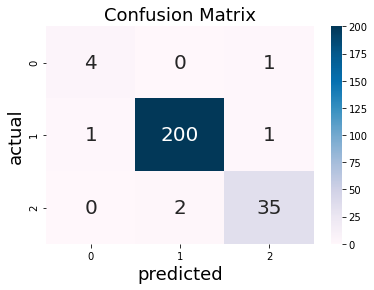

In [89]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report
import seaborn as sns 

y_true = test_generator.labels
y_pred = model2.predict(test_generator).argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print("f1 score: ","{:.2f}".format(f1))
sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
plt.xlabel('predicted', fontsize=18)
plt.ylabel('actual', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Test on Other Pictures

In [241]:
from skimage import io
img = io.imread("face-mask-detection/IMG_6841.png")      
print(img.shape)

(3088, 2316, 4)


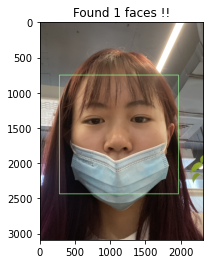

In [242]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
    gray_img,
    scaleFactor=1.01,
    minNeighbors=3,
    minSize=(1000, 1000)
)

plt.title(f"Found {len(faces)} faces !!")
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)
    plt.imshow(img)
plt.show()

In [243]:
def crop_image(file, xmin, ymin, xmax, ymax):
    im_arr = np.array(file)
    # cropping
    im_cropped = im_arr[ymin:ymax, xmin:xmax, :3]
    return im_cropped

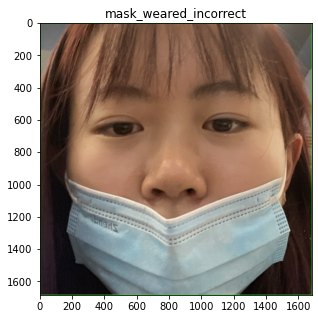

In [244]:
for (x, y, w, h) in faces:
    ymin, ymax, xmin, xmax = y, y+h, x, x+w
    im_cropped = crop_image(img, xmin, ymin, xmax, ymax)
    im_resized = cv2.resize(im_cropped, (35, 35))
    im_resized = im_resized / 255.0
    im_test = tf.constant([im_resized])
    y_pred = model2.predict(im_test).argmax(axis=1)
    plt.figure(figsize=(10,5))
    plt.title(list(test_generator.class_indices)[int(y_pred)])
    plt.imshow(im_cropped)

In [317]:
img = io.imread("face-mask-detection/crowd.jpeg")      
print(img.shape)

(485, 862, 3)


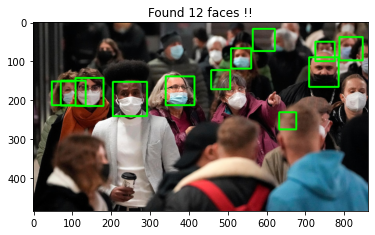

In [318]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
    gray_img,
    scaleFactor=1.01,
    minNeighbors=5,
    minSize=(40, 40),
    maxSize=(100,100)
)

plt.title(f"Found {len(faces)} faces !!")
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)
    plt.imshow(img)
plt.show()

In [319]:
def crop_image(file, xmin, ymin, xmax, ymax):
    im_arr = np.array(file)
    # cropping
    im_cropped = im_arr[ymin:ymax, xmin:xmax, :3]
    return im_cropped

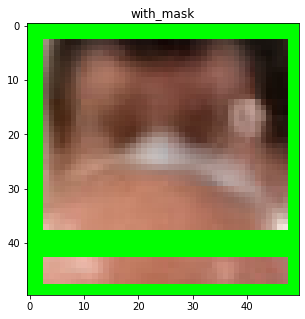

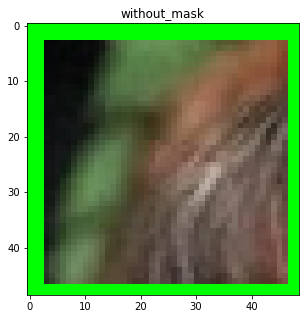

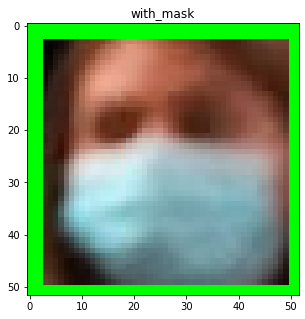

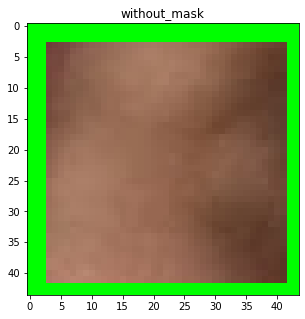

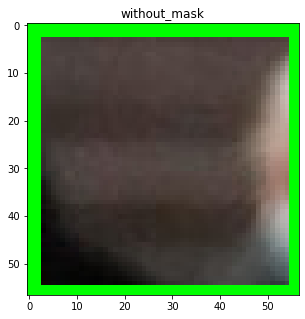

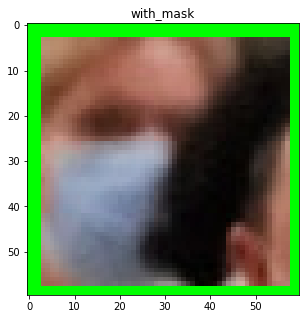

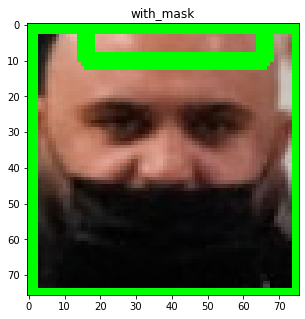

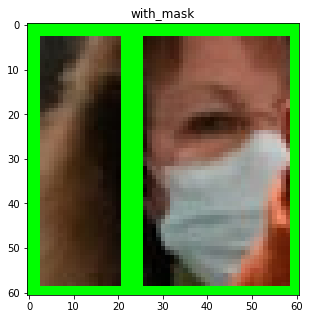

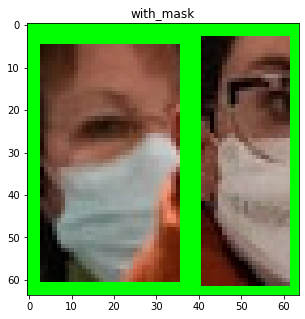

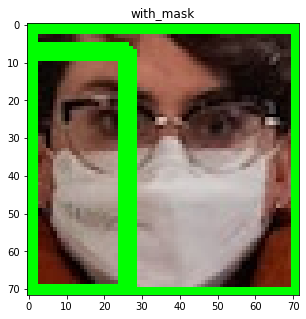

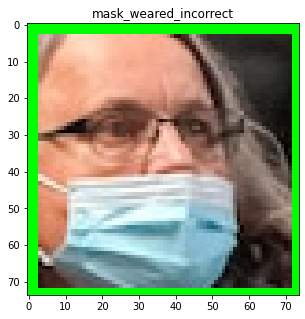

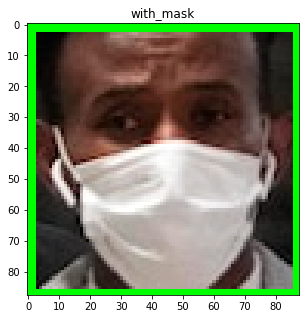

In [320]:
for (x, y, w, h) in faces:
    ymin, ymax, xmin, xmax = y, y+h, x, x+w
    im_cropped = crop_image(img, xmin, ymin, xmax, ymax)
    im_resized = cv2.resize(im_cropped, (35, 35))
    im_resized = im_resized / 255.0
    im_test = tf.constant([im_resized])
    y_pred = model2.predict(im_test).argmax(axis=1)
    plt.figure(figsize=(10,5))
    plt.title(list(test_generator.class_indices)[int(y_pred)])
    plt.imshow(im_cropped)